[![ebac_logo-data_science.png](https://raw.githubusercontent.com/earapanos/DataScienceExcercises/refs/heads/main/ebac_logo-data_science.png)](https://github.com/earapanos/DataScienceExcercises/tree/main)
<!-- <img src="https://raw.githubusercontent.com/earapanos/DataScienceExcercises/refs/heads/main/ebac_logo-data_science.png" alt="ebac_logo-data_science"> -->

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 38** | Streamlit IV e Pycaret | Exercício 1

**Aluno:** [Eduardo Adriani Rapanos](https://www.linkedin.com/in/eduardo-rapanos/)<br>
**Data:** 25 de maio de 2025.

---

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from scipy.stats import ks_2samp
from pycaret.classification import *

In [3]:
df = pd.read_feather(r'C:\Users\earap\Documents\EBAC\DataScienceExcercises\Módulo_38_-_Streamlit_IV_e_Pycaret\credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Converter data_ref para datetime e extrair mês/ano
df['data_ref'] = pd.to_datetime(df['data_ref'])
df['mes_ano'] = df['data_ref'].dt.to_period('M')

In [5]:
# Identificar os últimos 3 meses para validação OOT
ultimos_meses = df['mes_ano'].unique()[-3:]
print("Meses para validação OOT:", ultimos_meses)

Meses para validação OOT: <PeriodArray>
['2016-01', '2016-02', '2016-03']
Length: 3, dtype: period[M]


In [6]:
# Separar bases
df_oot = df[df['mes_ano'].isin(ultimos_meses)]
df_dev = df[~df['mes_ano'].isin(ultimos_meses)]

print(f"Base de desenvolvimento: {df_dev.shape[0]} linhas")
print(f"Base OOT: {df_oot.shape[0]} linhas")

Base de desenvolvimento: 600000 linhas
Base OOT: 150000 linhas


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Descritiva básica da base
print("\nNúmero de linhas totais:", df.shape[0])
print("\nContagem por mês:")
print(df['mes_ano'].value_counts().sort_index())


Número de linhas totais: 750000

Contagem por mês:
mes_ano
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


In [8]:
# Variáveis qualitativas e quantitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                'educacao', 'estado_civil', 'tipo_residencia']
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 
                'renda', 'mau']

In [9]:
# Descritiva qualitativas
print("\nDescritiva qualitativas:")
for var in qualitativas:
    print(f"\n{var}:")
    print(df[var].value_counts(normalize=True))


Descritiva qualitativas:

sexo:
sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64

posse_de_veiculo:
posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64

posse_de_imovel:
posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64

tipo_renda:
tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64

educacao:
educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.001083
Name: proportion, dtype: float64

estado_civil:
estado_civil
Casado      0.701963
Solteiro    0.122212
União       0.076913
Separado    0.056761
Viúvo       0.042151
Name: proportion, dtype: float64

tipo_residencia:
tipo_residencia
Casa             0.899059
Com os pais      0.044309
Governamental    0.031253
Aluguel         

In [10]:
# Descritiva quantitativas
print("\nDescritiva quantitativas:")
print(df[quantitativas].describe())


Descritiva quantitativas:
          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  


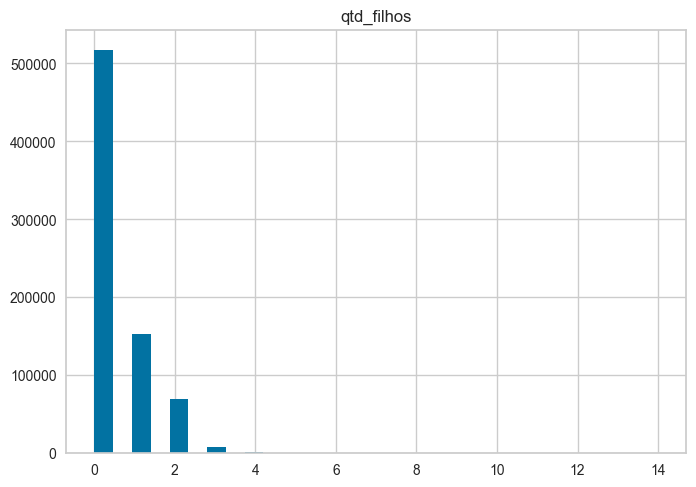

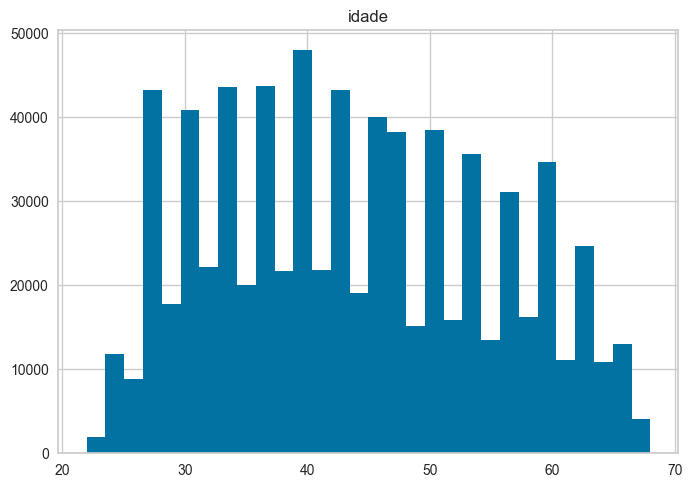

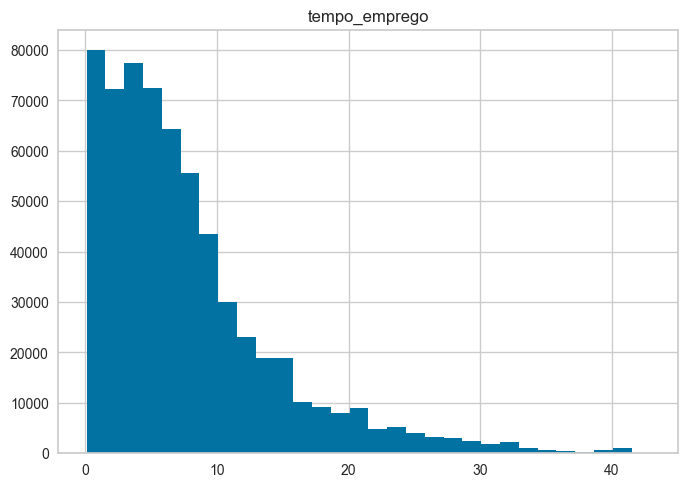

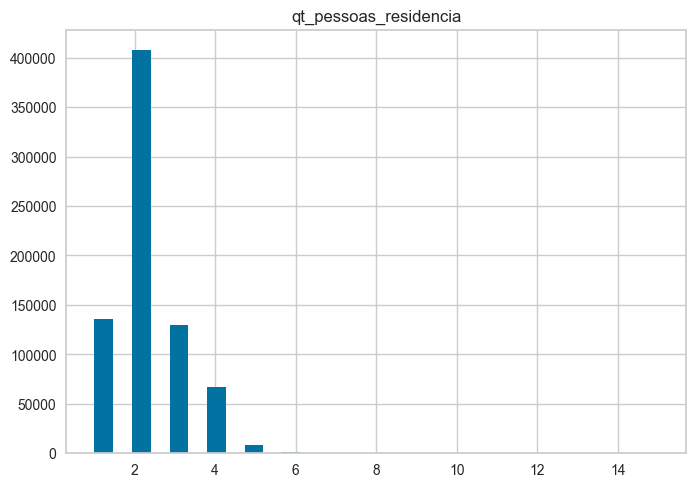

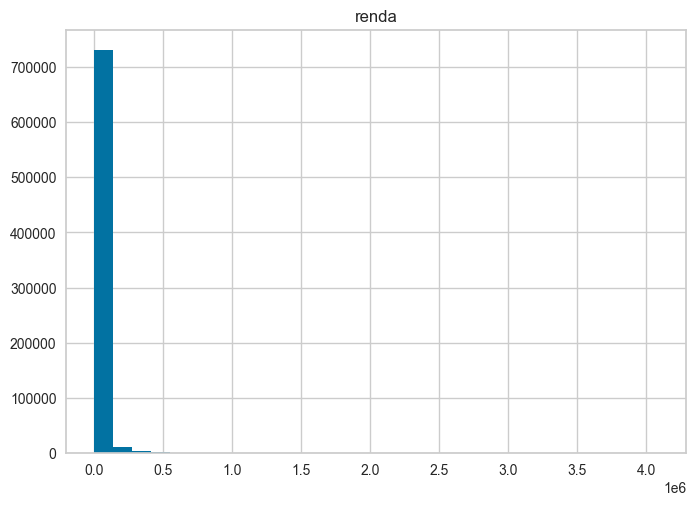

In [11]:
# Histogramas para variáveis quantitativas
for var in quantitativas:
    if var != 'mau':  # mau é nossa target binária
        plt.figure()
        df[var].hist(bins=30)
        plt.title(var)
        plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [12]:
# Análise bivariada com a target 'mau'
print("\nRelação com a variável target 'mau':")


Relação com a variável target 'mau':


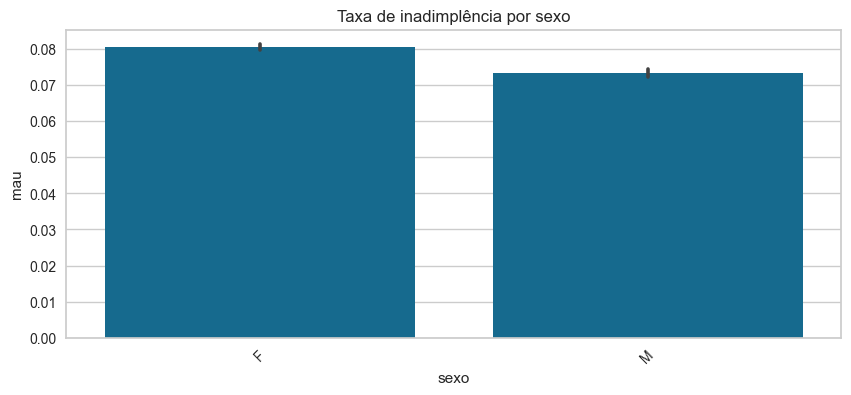

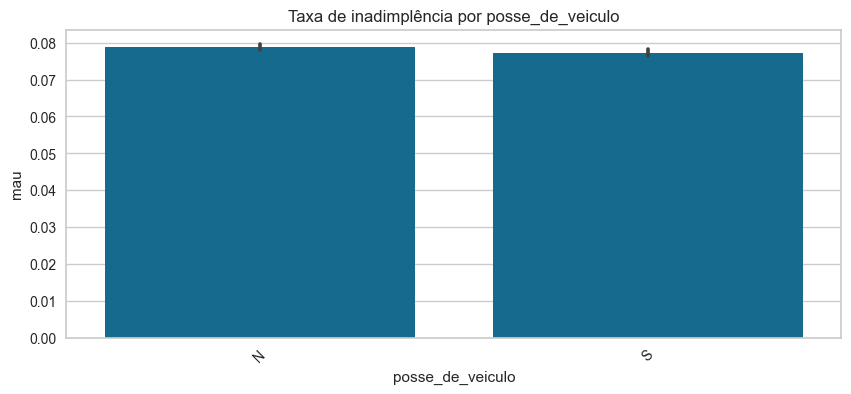

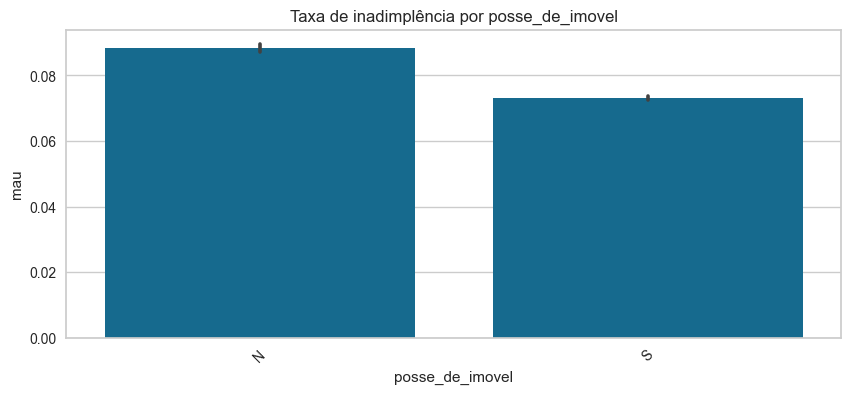

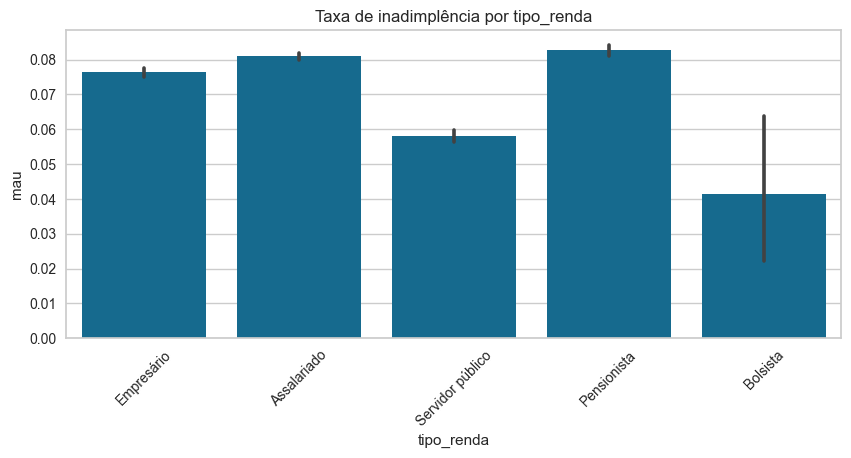

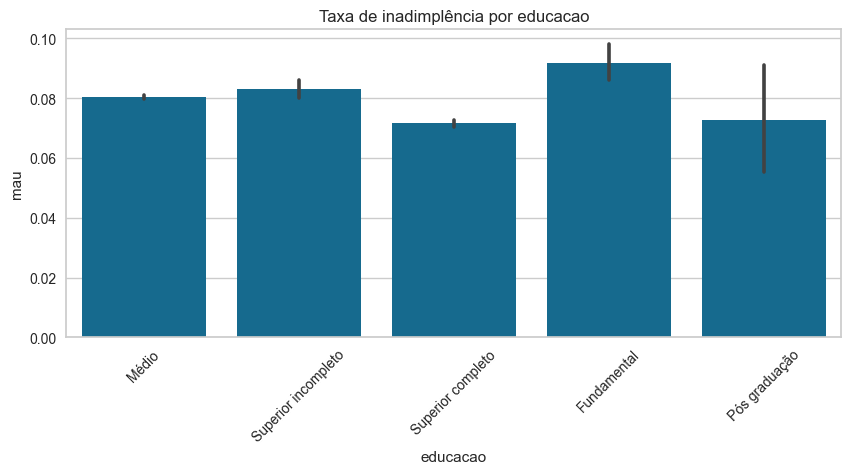

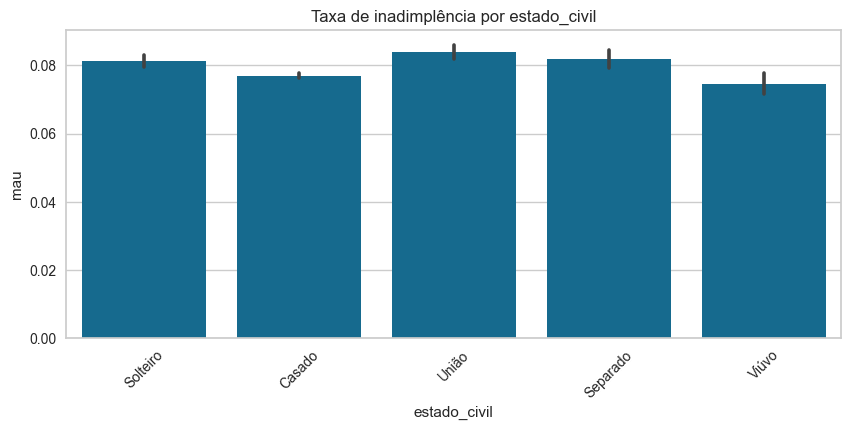

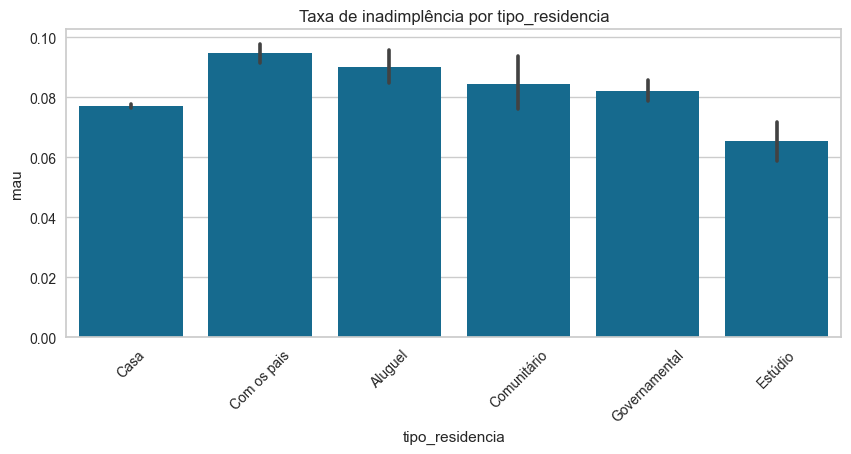

In [13]:
# Para qualitativas
for var in qualitativas:
    plt.figure(figsize=(10,4))
    sns.barplot(x=var, y='mau', data=df)
    plt.title(f'Taxa de inadimplência por {var}')
    plt.xticks(rotation=45)
    plt.show()

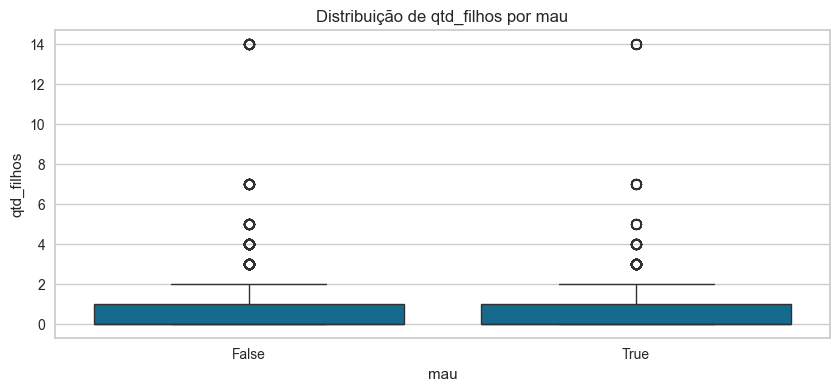

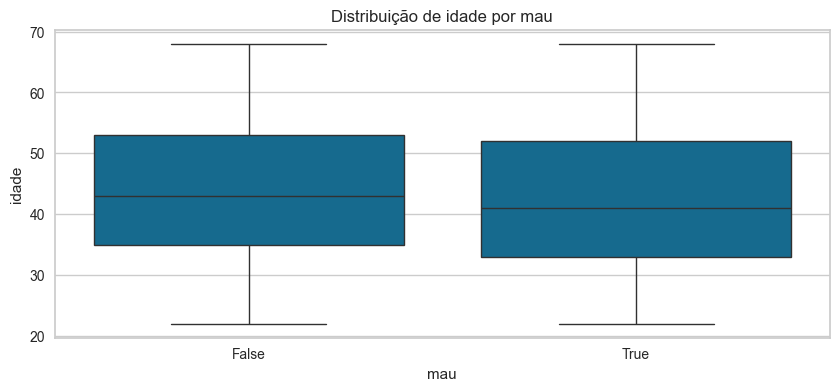

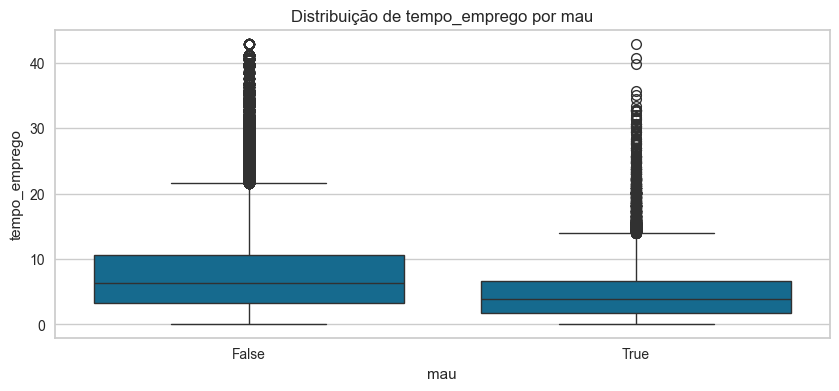

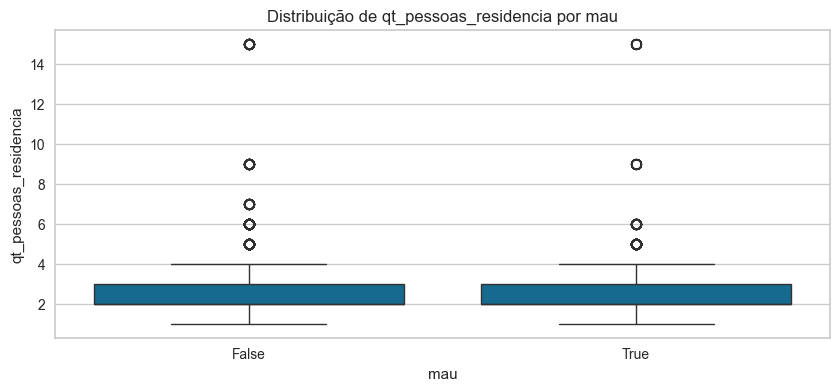

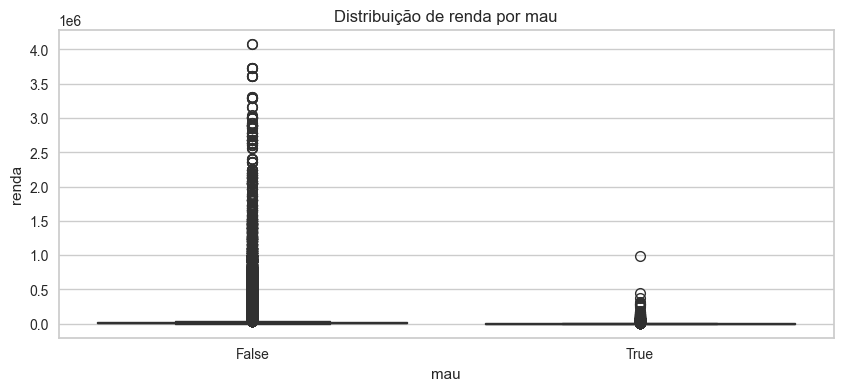

In [14]:
# Para quantitativas
for var in quantitativas:
    if var != 'mau':
        plt.figure(figsize=(10,4))
        sns.boxplot(x='mau', y=var, data=df)
        plt.title(f'Distribuição de {var} por mau')
        plt.show()

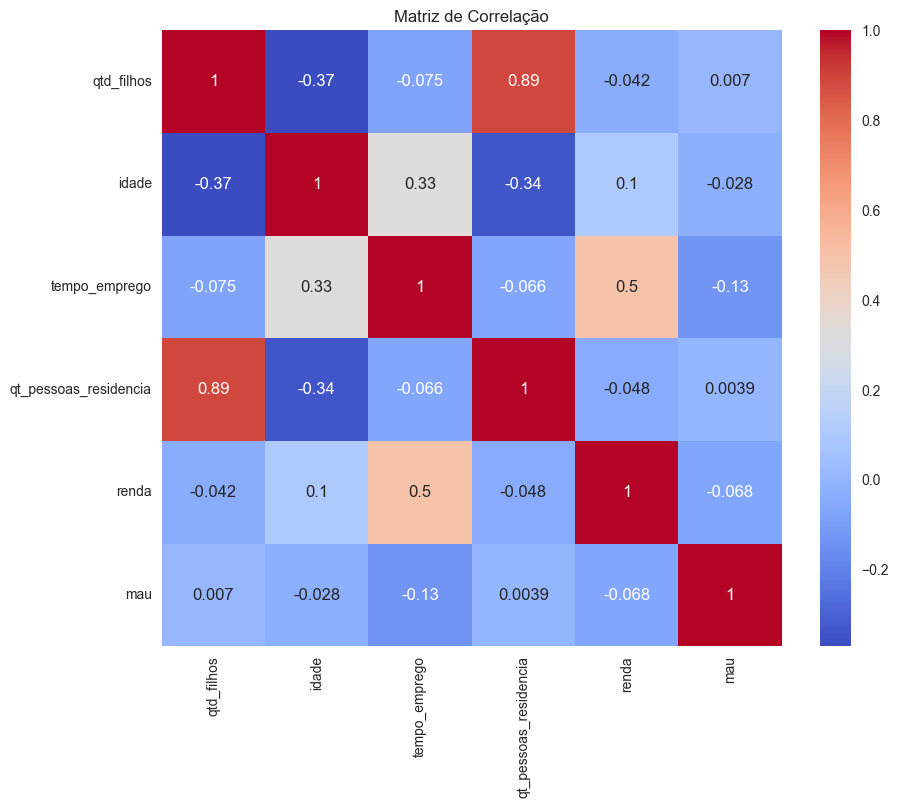

In [15]:
# Matriz de correlação
corr = df[quantitativas].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [16]:
# Tratamento de missings - vamos preencher tempo_emprego com a mediana
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [17]:
# Tratamento de outliers - vamos capar renda no percentil 99
renda_cap = df['renda'].quantile(0.99)
df['renda'] = df['renda'].apply(lambda x: renda_cap if x > renda_cap else x)

In [18]:
# Agrupamento de categorias com poucas observações
df['educacao'] = df['educacao'].replace({
    'Superior incompleto': 'Superior',
    'Superior completo': 'Superior',
    'Pós graduação': 'Superior'
})

df['tipo_residencia'] = df['tipo_residencia'].replace({
    'Estúdio': 'Outros',
    'Com os pais': 'Outros',
    'Aluguel': 'Outros',
    'Casa': 'Casa/Própria',
    'Própria': 'Casa/Própria'
})


In [19]:
# Seleção de variáveis finais
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 
            'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
            'educacao', 'estado_civil', 'tipo_residencia']
target = 'mau'

In [20]:
# Separar em treino e teste na base de desenvolvimento
X_dev = df_dev[features]
y_dev = df_dev[target]
X_oot = df_oot[features]
y_oot = df_oot[target]

X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.3, random_state=42)

In [21]:
# Pipeline de pré-processamento
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'educacao', 'estado_civil', 'tipo_residencia']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [22]:
# Pipeline completo com PCA e Regressão Logística
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression(max_iter=1000))])

In [23]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'educacao', 'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('classifier', LogisticRegression(max_iter=1000))])

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [24]:
# Avaliar o modelo
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]
    
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    
    # Cálculo do KS
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    ks = max(tpr - fpr)
    
    print(f"\nAvaliação para {dataset_name}:")
    print(f"Acurácia: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"KS: {ks:.4f}")
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend()
    plt.show()
    
    return acc, auc, ks


Desempenho do Modelo de Regressão Logística:

Avaliação para Treino:
Acurácia: 0.9396
AUC: 0.6878
KS: 0.2777


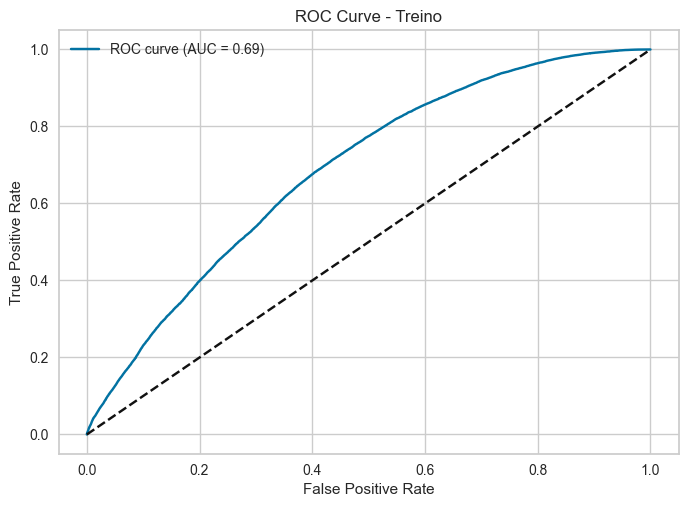


Avaliação para Teste:
Acurácia: 0.9373
AUC: 0.6853
KS: 0.2736


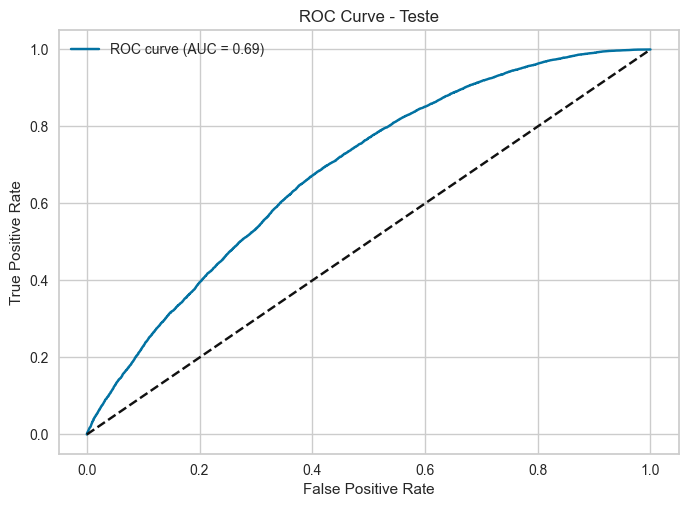


Avaliação para OOT:
Acurácia: 0.8533
AUC: 0.6573
KS: 0.2267


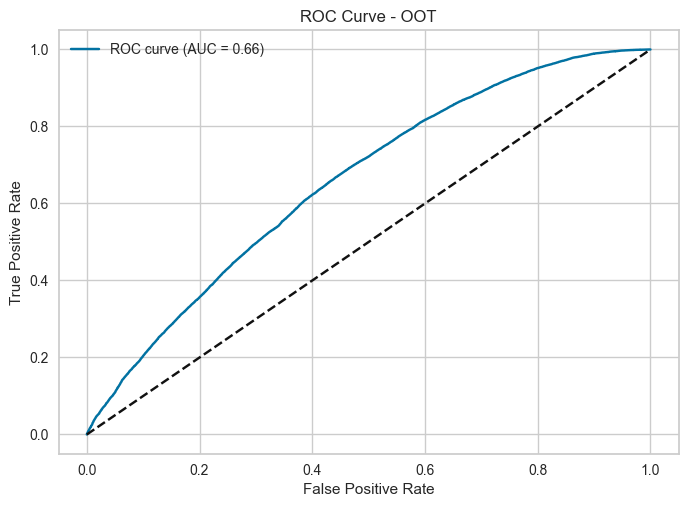

In [25]:
# Avaliar nas bases de treino, teste e OOT
print("\nDesempenho do Modelo de Regressão Logística:")
acc_train, auc_train, ks_train = evaluate_model(pipeline, X_train, y_train, "Treino")
acc_test, auc_test, ks_test = evaluate_model(pipeline, X_test, y_test, "Teste")
acc_oot, auc_oot, ks_oot = evaluate_model(pipeline, X_oot, y_oot, "OOT")

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [26]:
# Carregar os dados
df = pd.read_feather('credit_scoring.ftr')
print("Dados carregados com sucesso!")
df.head()

Dados carregados com sucesso!


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import time

# Configuração inicial
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Carregamento e Análise Inicial de Dados
def load_and_analyze_data():
    """Carrega e analisa os dados de forma otimizada"""
    # Tipos otimizados para economia de memória
    dtype = {
        'qtd_filhos': 'int8',
        'idade': 'int16',
        'tempo_emprego': 'float32',
        'qt_pessoas_residencia': 'int8',
        'renda': 'float32',
        'mau': 'bool'
    }
    
    # Carregar dados
    df = pd.read_feather('credit_scoring.ftr').astype(dtype)
    
    # Análise inicial
    print("\n🔍 Análise Inicial:")
    print(f"Total de linhas: {len(df)}")
    print(f"Proporção de 'mau': {df['mau'].mean():.2%}")
    print("\nValores nulos por coluna:")
    print(df.isnull().sum())
    
    return df

df = load_and_analyze_data()

## 2. Pré-processamento Adaptado
# Definir variáveis
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                       'educacao', 'estado_civil', 'tipo_residencia']
target = 'mau'

# Tratamento de outliers otimizado
class SmartOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method='iqr', threshold=1.5):
        self.method = method
        self.threshold = threshold
        
    def fit(self, X, y=None):
        if self.method == 'iqr':
            self.q1_ = X[numeric_features].quantile(0.25)
            self.q3_ = X[numeric_features].quantile(0.75)
            self.iqr_ = self.q3_ - self.q1_
        else:  # z-score
            self.mean_ = X[numeric_features].mean()
            self.std_ = X[numeric_features].std()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in numeric_features:
            if self.method == 'iqr':
                lower = self.q1_[col] - self.threshold * self.iqr_[col]
                upper = self.q3_[col] + self.threshold * self.iqr_[col]
            else:  # z-score
                lower = self.mean_[col] - self.threshold * self.std_[col]
                upper = self.mean_[col] + self.threshold * self.std_[col]
            
            mask = (X_copy[col] < lower) | (X_copy[col] > upper)
            X_copy.loc[mask, col] = np.nan
        return X_copy

# Pipeline numérico adaptado
numeric_transformer = Pipeline(steps=[
    ('outlier', SmartOutlierHandler(method='iqr')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline categórico adaptado
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processador completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    n_jobs=-1)

## 3. Modelagem e Avaliação
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """Função para treinar e avaliar modelos"""
    start_time = time.time()
    print(f"\nTreinando {model.__class__.__name__}...")
    
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Avaliação
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n⏱ Tempo de treinamento: {train_time:.2f} segundos")
    print("\n📊 Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    print("\n📈 Métricas Adicionais:")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Matriz de confusão formatada
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                        index=['Real Bom', 'Real Mau'], 
                        columns=['Predito Bom', 'Predito Mau'])
    print("\n🎯 Matriz de Confusão:")
    print(cm_df)
    
    return model

## 4. Pipeline Principal
def create_main_pipeline():
    return Pipeline([
        ('preprocessor', preprocessor),
        ('dim_reduction', PCA(n_components=0.95)),  # Mantém 95% da variância
        ('classifier', RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=10,
            n_jobs=-1,
            random_state=42,
            class_weight='balanced'  # Importante para dados desbalanceados
        ))
    ])

# Versão LightGBM (recomendada)
def create_lightgbm_pipeline():
    from lightgbm import LGBMClassifier
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=7,
            n_jobs=-1,
            random_state=42,
            is_unbalance=True
        ))
    ])

## 5. Execução Principal
# Preparação dos dados
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("\n🔢 Distribuição das classes:")
print(y_train.value_counts(normalize=True))

# Treinar e avaliar modelos
print("\n" + "="*50)
print("🚀 Modelo RandomForest")
print("="*50)
rf_model = create_main_pipeline()
rf_model = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)

print("\n" + "="*50)
print("💡 Modelo LightGBM (Recomendado)")
print("="*50)
lgbm_model = create_lightgbm_pipeline()
lgbm_model = train_and_evaluate(lgbm_model, X_train, y_train, X_test, y_test)

## 6. Feature Importance (Opcional)
def plot_feature_importance(model, feature_names, top_n=20):
    """Visualiza a importância das features"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importance = model.named_steps['classifier'].feature_importances_
    else:
        print("Modelo não suporta feature_importances_")
        return
    
    # Obter nomes das features após one-hot encoding
    if hasattr(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
        cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        all_features = numeric_features + list(cat_features)
    else:
        all_features = feature_names
    
    # Criar DataFrame com importâncias
    feat_imp = pd.DataFrame({
        'Feature': all_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp)
    plt.title(f'Top {top_n} Features por Importância')
    plt.show()

# Visualizar importância (para RandomForest)
def plot_feature_importance(model, feature_names, top_n=20):
    """Visualiza a importância das features corrigida"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    try:
        # Obter importâncias do modelo
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importance = model.named_steps['classifier'].feature_importances_
        else:
            print("Modelo não suporta feature_importances_")
            return
        
        # Obter nomes das features após transformação
        preprocessor = model.named_steps['preprocessor']
        
        # Features numéricas (mantêm seus nomes)
        num_features = numeric_features
        
        # Features categóricas (one-hot encoded)
        if hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
            cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        else:
            # Fallback para versões mais antigas
            cat_features = []
            for i, col in enumerate(categorical_features):
                cats = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i]
                for cat in cats:
                    cat_features.append(f"{col}_{cat}")
        
        all_features = list(num_features) + list(cat_features)
        
        # Verificar compatibilidade de tamanhos
        if len(importance) != len(all_features):
            print(f"Aviso: Número de importâncias ({len(importance)}) diferente do número de features ({len(all_features)})")
            print("Usando apenas as primeiras features correspondentes...")
            min_length = min(len(importance), len(all_features))
            importance = importance[:min_length]
            all_features = all_features[:min_length]
        
        # Criar DataFrame com importâncias
        feat_imp = pd.DataFrame({
            'Feature': all_features,
            'Importance': importance
        }).sort_values('Importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp)
        plt.title(f'Top {top_n} Features por Importância')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao plotar importância das features: {str(e)}")


🔍 Análise Inicial:
Total de linhas: 750000
Proporção de 'mau': 7.82%

Valores nulos por coluna:
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

🔢 Distribuição das classes:
mau
False    0.92181
True     0.07819
Name: proportion, dtype: float64

🚀 Modelo RandomForest

Treinando Pipeline...

⏱ Tempo de treinamento: 80.71 segundos

📊 Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.96      0.70      0.81    207407
        True       0.17      0.69      0.27     17593

    accuracy                 

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [28]:
from pycaret.classification import *
import pandas as pd

In [29]:
from pycaret.classification import *
import pandas as pd

# 1. Carregar e preparar os dados
df = pd.read_feather('credit_scoring.ftr')
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 
            'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
            'educacao', 'estado_civil', 'tipo_residencia', 'mau']
df = df[features]

# 2. Configuração universal do ambiente
try:
    # Tentativa para versões mais recentes (3.0+)
    setup_args = {
        'data': df,
        'target': 'mau',
        'train_size': 0.7,
        'normalize': True,
        'transformation': True,
        'fix_imbalance': True,
        'session_id': 42,
        'verbose': False,
        'low_variance_threshold': 0.9,  # Novo nome do parâmetro
        'remove_multicollinearity': True,
        'multicollinearity_threshold': 0.9
    }
    
    # Verificar e remover parâmetros não suportados
    import inspect
    setup_params = inspect.signature(setup).parameters
    for key in list(setup_args.keys()):
        if key not in setup_params:
            del setup_args[key]
    
    clf = setup(**setup_args)

except Exception as e:
    # Fallback para versões mais antigas
    print(f"Usando configuração alternativa: {str(e)}")
    clf = setup(data=df, 
                target='mau',
                train_size=0.7,
                silent=True,  # Equivalente a verbose=False em versões antigas
                normalize=True,
                transformation=True,
                ignore_low_variance=True,  # Nome antigo do parâmetro
                remove_multicollinearity=True,
                multicollinearity_threshold=0.9,
                fix_imbalance=True,
                session_id=42)

# 3. Modelagem com LightGBM
lgbm = create_model('lightgbm', cross_validation=True)

# 4. Otimização do modelo
tuned_lgbm = tune_model(lgbm, optimize='AUC')

# 5. Avaliação final
evaluate_model(tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8642,0.7753,0.3859,0.2558,0.3076,0.2358,0.2419
1,0.8588,0.7769,0.4161,0.2541,0.3155,0.2419,0.2510
2,0.8592,0.7789,0.4056,0.2515,0.3105,0.2369,0.2453
3,0.8659,0.7855,0.4063,0.2659,0.3215,0.2507,0.2576
4,0.8628,0.7772,0.4056,0.2590,0.3161,0.2440,0.2516
5,0.8628,0.7786,0.4073,0.2595,0.3170,0.2449,0.2526
6,0.8622,0.7738,0.4024,0.2568,0.3135,0.2410,0.2486
7,0.8638,0.7757,0.4034,0.2606,0.3166,0.2449,0.2521
8,0.8635,0.7780,0.4088,0.2616,0.3190,0.2472,0.2548


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6907,0.7788,0.7306,0.1654,0.2698,0.1630,0.2360
1,0.6933,0.7814,0.7259,0.1659,0.2701,0.1637,0.2357
2,0.6898,0.7829,0.7311,0.1650,0.2693,0.1624,0.2355
3,0.6712,0.7893,0.7693,0.1622,0.2679,0.1593,0.2402
4,0.6696,0.7795,0.7474,0.1583,0.2613,0.1518,0.2283
5,0.6911,0.7818,0.7240,0.1646,0.2682,0.1614,0.2330
6,0.6688,0.7775,0.7527,0.1588,0.2622,0.1528,0.2304
7,0.6929,0.7794,0.7267,0.1659,0.2701,0.1636,0.2357
8,0.6696,0.7810,0.7547,0.1594,0.2632,0.1540,0.2319


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…